# cisTopic

In [25]:
# Packages
library(cisTopic)
library(Seurat)
library(Signac)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())

# set random seed for reproducibility
set.seed(12345)

In [38]:
input_rds <- "/cellar/users/aklie/projects/igvf/beta_cell_networks/data/multiome_stimulated_sc/igvf/data/multiome/DM023_palmitate/rds/01sep22_igvf_mo1.qc.rds"
output_directory <- "/cellar/users/aklie/projects/igvf/beta_cell_networks/bin/infer_cellular_programs/cistopic/results/multiome_stimulated_sc"

# create output directory if it doesn't exist
if (!dir.exists(output_directory)) {
  dir.create(output_directory, showWarnings = FALSE)
}

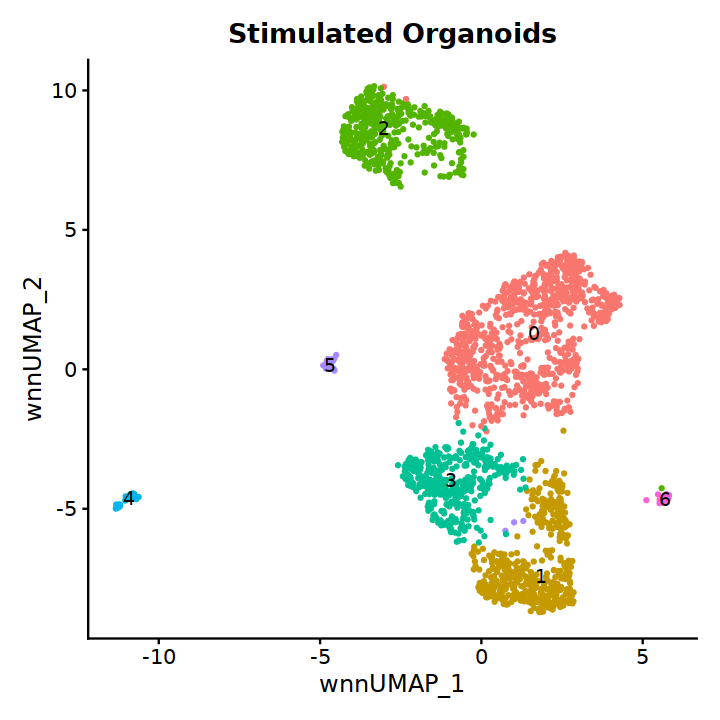

In [33]:
# Double check the umaps for clustering
options(repr.plot.width=6, repr.plot.height=6)
p1 <- DimPlot(ad, reduction="umap.wnn", group.by='seurat_clusters', label=TRUE) + ggtitle('Stimulated Organoids') + NoLegend()
p1

# Get ATAC matrix

In [19]:
ad <- readRDS(input_rds)
m <- GetAssayData(object = ad, assay="ATAC", slot = "counts")
m@x <- rep(1, length(m@i))
rownames(m) <- sub("-", ":", rownames(m))
dim(m)

[1] 134202   2178

# Run model

In [26]:
cisTopicObject <- createcisTopicObject(m, project.name='multiome_stimulated_sc')
cisTopicObject <- addCellMetadata(cisTopicObject, cell.data = ad@meta.data)

In [40]:
cisTopicObject <- runCGSModels(cisTopicObject, topic=c(2,3,4), seed=123, nCores=3, burnin = 5, iterations = 10, addModels=FALSE)
cisTopicObject

[1] "Formatting data..."
[1] "Exporting data..."
[1] "Running models..."


An object of class cisTopic in project multiome_stimulated_sc 
 134202 regions across 2178 samples.

# Some evaluations

In [43]:
pdf(file.path(output_directory, "select_models.pdf"), 10, 5)
par(mfrow=c(1,2))
cisTopicObject <- selectModel(cisTopicObject, type="maximum")
dev.off()

png 
  2

In [44]:
n_topics <- c(2, 3, 4)
pdf(file.path(output_directory, "convergence.pdf"), 5, 5)
logLikelihoodByIter(cisTopicObject, select=n_topics)
dev.off()

png 
  2

Warning message in dir.create(file.path(output_directory, "models")):
“'/cellar/users/aklie/projects/igvf/beta_cell_networks/bin/infer_cellular_programs/cistopic/results/multiome_stimulated_sc/models' already exists”


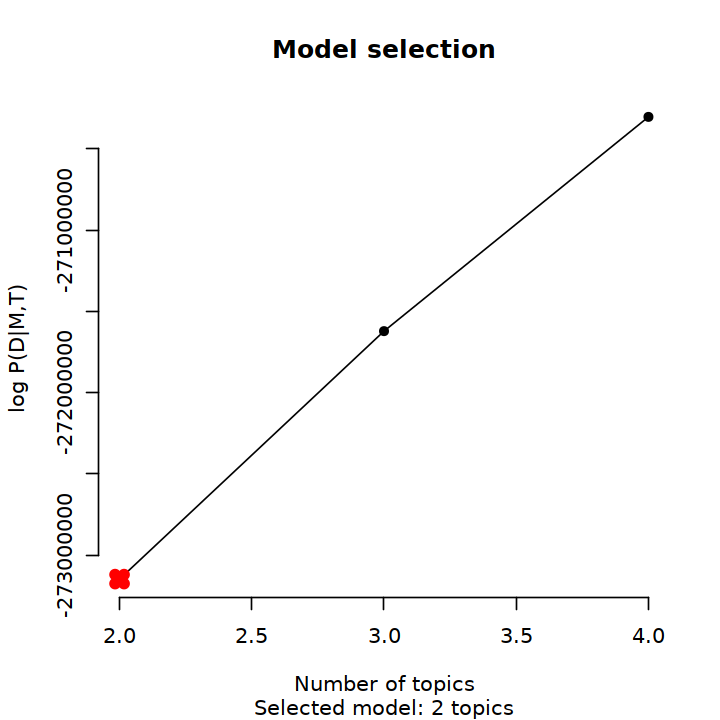

[1] 1


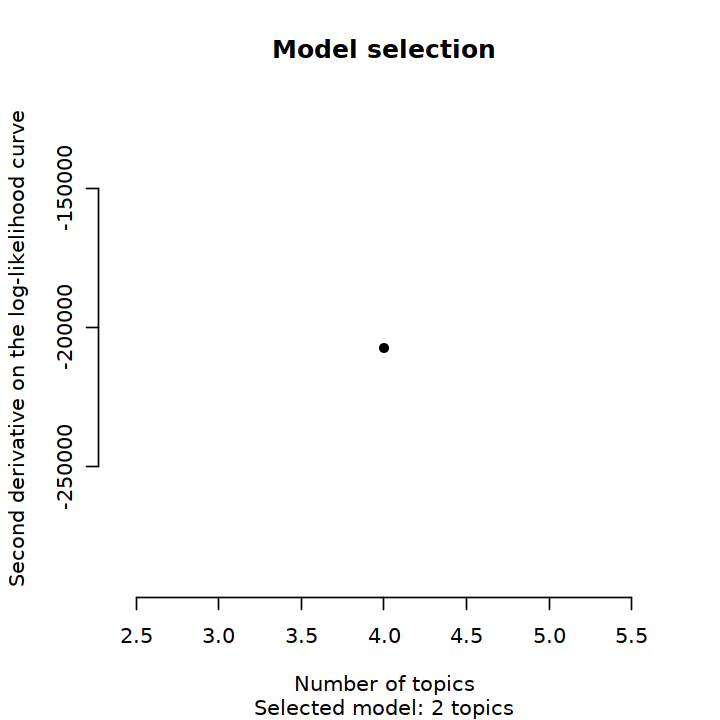

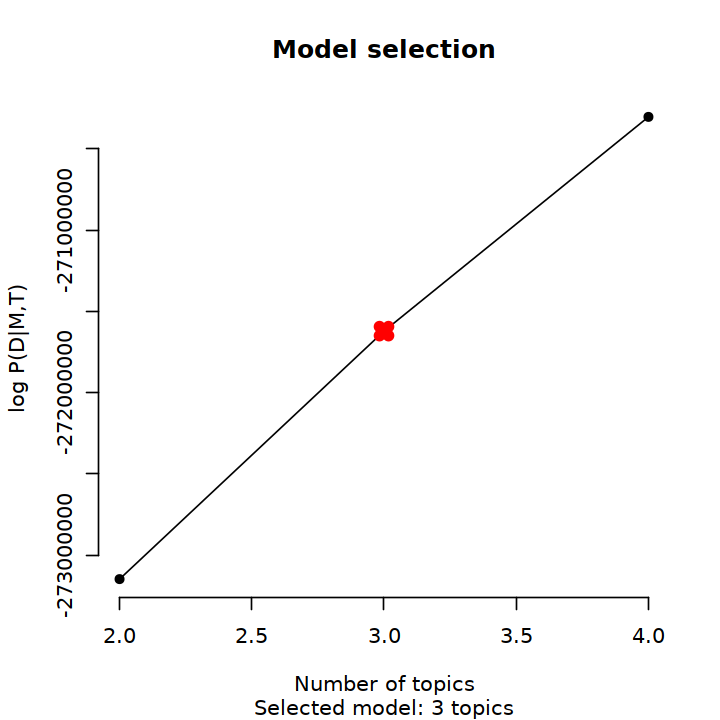

[1] 2


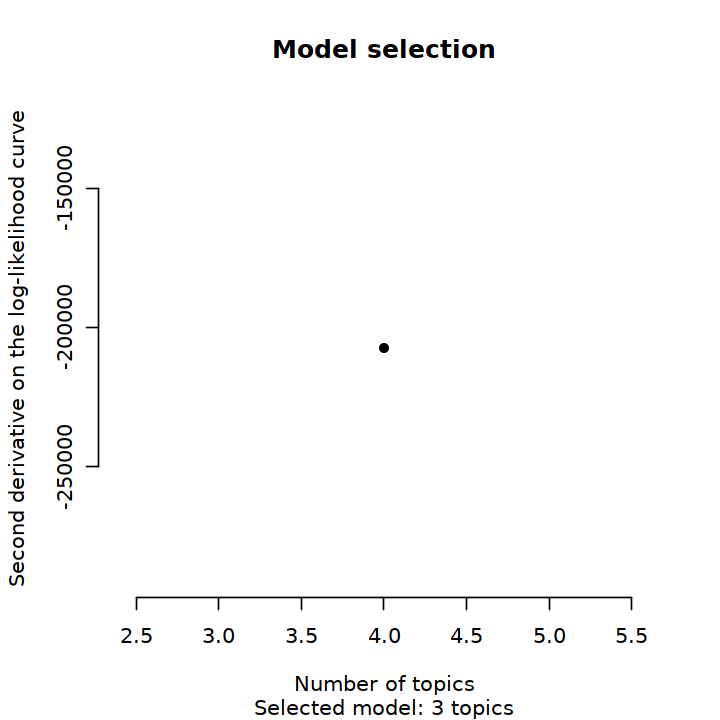

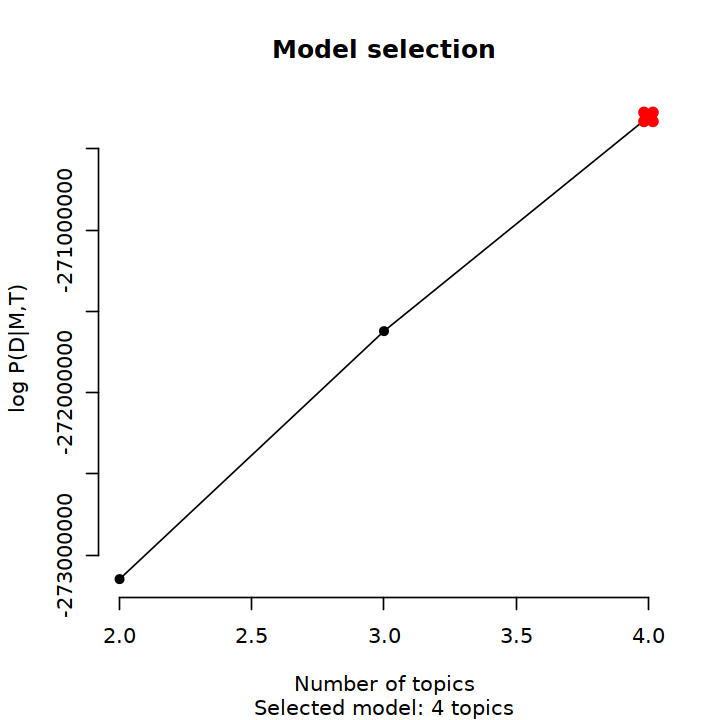

[1] 3


pdf 
  3

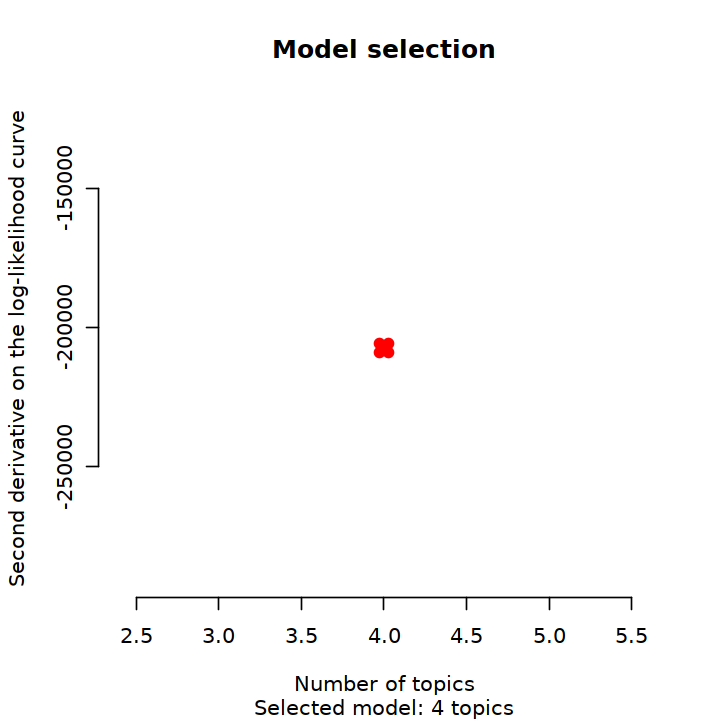

In [46]:
# save all models
dir.create(file.path(output_directory, 'models'))
for (i in 1:length(n_topics)) {
  a <- selectModel(cisTopicObject, select=n_topics[i], type="maximum")
  cellassign <- modelMatSelection(a, 'cell', 'Probability')
  write.csv(t(cellassign), file=file.path(output_directory, sprintf("models/topics_%d.csv", n_topics[i])))
  print(i)
}
dev.off()

# Scratch

## Previous load

In [ ]:
# Load in the preprocessed Seurat object
RDS_FILE = "/cellar/users/aklie/data/igvf/beta_cell_networks/multiome_stimulated_sc/14sep22_DM023_palmitate_endocrine.rds"
adata <- readRDS(RDS_FILE)

# Check it!
adata

## Converting cisTopic object to pyCisTopic object

In [ ]:
cisTopicObj <- readRDS("t2d_beta_cells/test.cisTopic.rds")

In [ ]:
cellTopicHeatmap(cisTopicObj, method='Z-score', colorBy=c('densityClust'), col.low = "dodgerblue", col.mid = "floralwhite", col.high = "brown1")

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust


Loading required package: ComplexHeatmap

Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [4]:
library(arrow)


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp




In [3]:
path <- "t2d_beta_cells/"

In [2]:
cisTopic_obj <- readRDS("t2d_beta_cells/test.cisTopic.rds")

In [4]:
cisTopic_obj@selected.model <- cisTopic_obj@models$`30`

In [5]:
dim(cisTopic_obj@selected.model$topics)

[1]     30 185580

In [11]:
modelMat <- modelMatSelection(cisTopic_obj, 'cell', 'Probability')
modelMat <- as.data.frame(modelMat)
write_feather(modelMat, sink=paste0(path, 'model_to_pycisTopic/cell_topic.feather'))

In [12]:
modelMat <- modelMatSelection(cisTopic_obj, 'region', 'Probability', all.regions=TRUE)
modelMat <- as.data.frame(modelMat)
write_feather(modelMat, sink=paste0(path, 'model_to_pycisTopic/topic_region.feather'))

In [12]:
# You can also save the count.matrix
ct <- cisTopic_obj@count.matrix
ct <- as.data.frame(ct)
write_feather(ct, sink=paste0(path, 'model_to_pycisTopic/count_matrix.feather'))

ERROR: Error: x must be an object of class 'data.frame', 'RecordBatch', or 'Table', not 'dgCMatrix'.


In [16]:
Matrix::writeMM(ct, paste0(path, 'model_to_pycisTopic/count_matrix.mtx'))

NULL

In [17]:
write.table(cisTopic_obj@cell.data, paste0(path, 'model_to_pycisTopic/cell_data.tsv'), sep="\t")

In [18]:
write.table(cisTopic_obj@region.data, paste0(path, 'model_to_pycisTopic/region_data.tsv'), sep="\t")

Loading required package: Signac



An object of class Seurat 
696827 features across 16342 samples within 6 assays 
Active assay: SCT (28796 features, 3000 variable features)
 5 other assays present: RNA, RNA_raw, ATAC, mpeak, peaks
 9 dimensional reductions calculated: lsi, harmony.atac, pca, harmony.sct, umap.wnn, umap.atac, umap.sct, harmony.peaks, umap.peaks